# Submitted by: Aaryan Verma

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageFilter
import cv2
import json
from os import listdir
from os.path import isfile, join
from imutils import contours

# Plate Detector - Tries to detect plates from input image

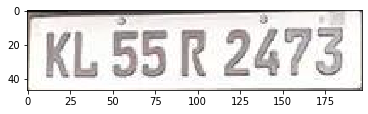

In [32]:
img = cv2.imread("E:\\Machine_Learning_Models\\numberplate_dataset\\Cars\\10.jpg")
#convert my image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#perform adaptive threshold so that I can extract proper contours from the image
#need this to extract the name plate from the image. 
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
_,contours,h = cv2.findContours(thresh,1,2)

#once I have the contours list, i need to find the contours which form rectangles.
#the contours can be approximated to minimum polygons, polygons of size 4 are probably rectangles
largest_rectangle = [0,0]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    if len(approx)==4: #polygons with 4 points is what I need.
        area = cv2.contourArea(cnt)
        if area > largest_rectangle[0]:
            #find the polygon which has the largest size.
            largest_rectangle = [cv2.contourArea(cnt), cnt, approx]

x,y,w,h = cv2.boundingRect(largest_rectangle[1])
#crop the rectangle to get the number plate.
roi=img[y:y+h,x:x+w]
#cv2.drawContours(img,[largest_rectangle[1]],0,(0,0,255),-1)
plt.imshow(roi, cmap = 'gray')
plt.show()

# Find Contour on license plate

In [34]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    _, cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    ii = cv2.imread('contour.jpg')
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

# Segmenting Characters in License Plate

In [37]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img = cv2.resize(image, (333, 75))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_erode = cv2.erode(img_binary, (3,3))
    img_dilate = cv2.dilate(img_erode, (3,3))

    LP_WIDTH = img_dilate.shape[0]
    LP_HEIGHT = img_dilate.shape[1]

    # Make borders white
    img_dilate[0:3,:] = 255
    img_dilate[:,0:3] = 255
    img_dilate[72:75,:] = 255
    img_dilate[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    plt.imshow(img_dilate, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_dilate)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_dilate)

    return char_list

# Training Neural Network for OCR of License Plates

In [210]:
import tensorflow as tf
from keras.preprocessing import image

Using TensorFlow backend.


In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'E:/Machine_Learning_Models/numberplate_dataset/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'E:/Machine_Learning_Models/numberplate_dataset/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [106]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [114]:
batch_size = 1
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 20)

Epoch 1/20
864/864 [==============================] - 81s 94ms/step - loss: 1.7259 - accuracy: 0.5463 - val_loss: 1.5321 - val_accuracy: 0.6906
Epoch 2/20
864/864 [==============================] - 81s 94ms/step - loss: 1.4763 - accuracy: 0.6146 - val_loss: 1.2875 - val_accuracy: 0.7361
Epoch 3/20
864/864 [==============================] - 82s 94ms/step - loss: 1.2383 - accuracy: 0.6597 - val_loss: 1.1414 - val_accuracy: 0.7472
Epoch 4/20
864/864 [==============================] - 85s 98ms/step - loss: 1.1456 - accuracy: 0.6748 - val_loss: 1.0004 - val_accuracy: 0.7855
Epoch 5/20
864/864 [==============================] - 83s 96ms/step - loss: 0.9695 - accuracy: 0.7442 - val_loss: 0.8865 - val_accuracy: 0.7951
Epoch 6/20
864/864 [==============================] - 84s 97ms/step - loss: 0.8905 - accuracy: 0.7431 - val_loss: 0.7936 - val_accuracy: 0.8248
Epoch 7/20
864/864 [==============================] - 82s 95ms/step - loss: 0.8182 - accuracy: 0.7812 - val_loss: 0.7166 - val_accuracy:

### Got accuracy of 91 percent in training set and test set

# Predicting Text from Images

In [300]:
model.save('plate_model.h5')

In [6]:
from tensorflow.keras.models import load_model

In [7]:
model=load_model('plate_model.h5')

In [207]:
mypath="E:\\Machine_Learning_Models\\numberplate_dataset\\Plates\\"

In [8]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    if len(char)!=0:
        for i,ch in enumerate(char): #iterating over the characters
            img_ = cv2.resize(ch, (28,28))
            img = fix_dimension(img_)
            img = img.reshape(1,28,28,3) #preparing image for the model
            y_ = model.predict_classes(img)[0] #predicting the class
            character = dic[y_] #
            output.append(character) #storing the result in a list
    else:
        output="Cannot see the number plate, use another image"

    plate_number = ''.join(output)
    
    return plate_number



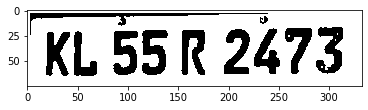

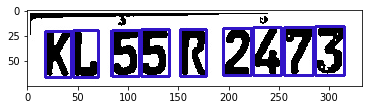

KL55R2473


In [38]:
char = segment_characters(roi)
print(show_results())